In [2]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [3]:
df = pd.read_csv('../data/trec07p.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75419 entries, 0 to 75418
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       75419 non-null  int64 
 1   subject     74626 non-null  object
 2   email_to    74843 non-null  object
 3   email_from  75419 non-null  object
 4   message     73932 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.9+ MB


,label,subject,email_to,email_from,message
0,1,"Generic Cialis, branded quality@",the00@speedy.uwaterloo.ca,"""Tomas Jacobs"" <RickyAmes@aol.com>",Content-Type: text/html;\nContent-Transfer-Enc...
1,0,Typo in /debian/README,debian-mirrors@lists.debian.org,Yan Morin <yan.morin@savoirfairelinux.com>,"Hi, i've just updated from the gulus and I che..."
2,1,authentic viagra,<the00@plg.uwaterloo.ca>,"""Sheila Crenshaw"" <7stocknews@tractionmarketin...","Content-Type: text/plain;\n\tcharset=""iso-8859..."
3,1,Nice talking with ya,opt4@speedy.uwaterloo.ca,"""Stormy Dempsey"" <vqucsmdfgvsg@ruraltek.com>","Hey Billy, \n\nit was really fun going out the..."
4,1,or trembling; stomach cramps; trouble in sleep...,ktwarwic@speedy.uwaterloo.ca,"""Christi T. Jernigan"" <dcube@totalink.net>",Content-Type: multipart/alternative;\n ...


In [4]:
print(df['label'].value_counts())

label
1    50199
0    25220
Name: count, dtype: int64


In [5]:
df.dropna(subset=['message'], inplace=True)

In [6]:
df = df[['label', 'message']]
df.rename(columns={'message': 'text'}, inplace=True)

In [7]:
df['label'] = df['label'].map({1: 'spam', 0: 'ham'})

In [8]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower() # Ensure text is a string
    text = re.sub(r'[^\w\s]', '', text)
    words = word_tokenize(text)
    cleaned_words = [word for word in words if word not in stop_words]
    return " ".join(cleaned_words)

In [10]:
df['cleaned_text'] = df['text'].apply(clean_text)
df.head()

,label,text,cleaned_text
0,spam,Content-Type: text/html;\nContent-Transfer-Enc...,contenttype texthtml contenttransferencoding 7...
1,ham,"Hi, i've just updated from the gulus and I che...",hi ive updated gulus check mirrors seems littl...
2,spam,"Content-Type: text/plain;\n\tcharset=""iso-8859...",contenttype textplain charsetiso88591 contentt...
3,spam,"Hey Billy, \n\nit was really fun going out the...",hey billy really fun going night talking said ...
4,spam,Content-Type: multipart/alternative;\n ...,contenttype multipartalternative boundary_next...


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
vectorizer = TfidfVectorizer(max_features=5000)

X = vectorizer.fit_transform(df['cleaned_text']).toarray()
y = df['label']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (59145, 5000)
Shape of X_test: (14787, 5000)
Shape of y_train: (59145,)
Shape of y_test: (14787,)


In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [15]:
model = MultinomialNB()
model.fit(X_train, y_train)
print("Model training complete.")

Model training complete.


In [16]:
y_pred = model.predict(X_test)

In [17]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='spam')
recall = recall_score(y_test, y_pred, pos_label='spam')
f1 = f1_score(y_test, y_pred, pos_label='spam')

In [18]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.9617
Precision: 0.9949
Recall: 0.9466
F1-Score: 0.9702


In [19]:
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))

              precision    recall  f1-score   support

         ham       0.91      0.99      0.95      5044
        spam       0.99      0.95      0.97      9743

    accuracy                           0.96     14787
   macro avg       0.95      0.97      0.96     14787
weighted avg       0.96      0.96      0.96     14787



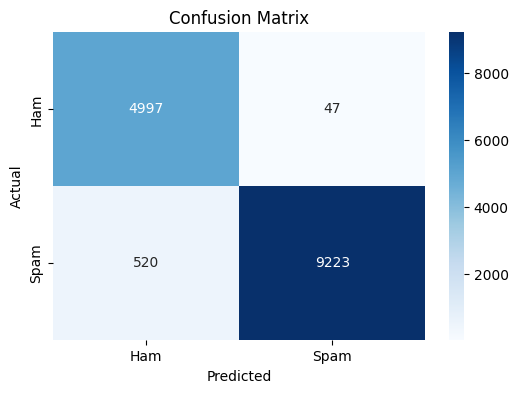

In [20]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [21]:
model_path = '../saved_models/spam_classifier_model.joblib'
vectorizer_path = '../saved_models/tfidf_vectorizer.joblib'

joblib.dump(model, model_path)

joblib.dump(vectorizer, vectorizer_path)

print(f"\nModel saved to: {model_path}")
print(f"Vectorizer saved to: {vectorizer_path}")


Model saved to: ../saved_models/spam_classifier_model.joblib
Vectorizer saved to: ../saved_models/tfidf_vectorizer.joblib
